In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load the data into a DataFrame
df = pd.read_csv('MLdf.csv')
df

,date,siteid,nitrate_mean,spec_conductance,DO,pH,chlorophyll,turbidity,fDOM,mean_temp,...,ln_nitrate_mean,ln_spec_conductance,ln_DO,ln_chlorophyll,ln_turbidity,ln_fDOM,ln_CH4_conc,ln_CO2_conc,ln_N2O_conc,ln_Microbialabundanceper_ml
0,2018-01-01,ARIK,13.700000,539.059444,10.186389,7.822500,2.095000,2.899444,45.220000,2.302477,...,2.617396,6.289826,2.321052,0.739554,1.064519,3.811539,3.250097,7.391244,-0.710933,10.871886
1,2018-01-02,ARIK,13.700000,539.059444,10.186389,7.822500,2.095000,2.899444,45.220000,2.302477,...,2.617396,6.289826,2.321052,0.739554,1.064519,3.811539,3.250097,7.391244,-0.710933,10.871886
2,2018-01-03,ARIK,13.700000,539.059444,10.186389,7.822500,2.095000,2.899444,45.220000,2.302477,...,2.617396,6.289826,2.321052,0.739554,1.064519,3.811539,3.250097,7.391244,-0.710933,10.871886
3,2018-01-04,ARIK,12.535417,546.480042,9.921785,7.812403,3.249465,60.369840,45.220000,2.302477,...,2.528558,6.303498,2.294733,1.178490,4.100490,3.811539,3.250097,7.391244,-0.710933,10.871886
4,2018-01-05,ARIK,10.310417,550.830208,9.721729,7.826743,5.565236,2.548007,45.220000,2.302477,...,2.333155,6.311427,2.274364,1.716539,0.935311,3.811539,3.250097,7.391244,-0.710933,10.871886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23441,2020-12-27,WLOU,0.001000,298.291892,11.899740,8.146028,0.220042,0.959097,16.215236,17.389790,...,-6.907755,5.698073,2.476517,-1.513938,-0.041763,2.785951,1.032457,6.691841,-0.320212,10.901399
23442,2020-12-28,WLOU,0.041758,12.105146,8.384253,6.651626,0.900684,2.639976,31.655028,10.173155,...,-3.175858,2.493631,2.126355,-0.104601,0.970770,3.454897,1.032457,6.691841,-0.320212,10.901399
23443,2020-12-29,WLOU,4.188542,613.853512,10.900608,7.869108,9.817500,0.600420,4.082917,4.325872,...,1.432353,6.419756,2.388819,2.284167,-0.510126,1.406812,1.032457,6.691841,-0.320212,10.901399
23444,2020-12-30,WLOU,54.432292,176.735399,14.561951,7.948806,1.642281,2.160620,142.774583,3.839380,...,3.996958,5.174654,2.678412,0.496086,0.770395,4.961267,1.032457,6.691841,-0.320212,10.901399


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23446 entries, 0 to 23445
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         23446 non-null  object 
 1   siteid                       23446 non-null  object 
 2   nitrate_mean                 23446 non-null  float64
 3   spec_conductance             23446 non-null  float64
 4   DO                           23446 non-null  float64
 5   pH                           23446 non-null  float64
 6   chlorophyll                  23446 non-null  float64
 7   turbidity                    23446 non-null  float64
 8   fDOM                         23446 non-null  float64
 9   mean_temp                    23446 non-null  float64
 10  CH4_conc                     23446 non-null  float64
 11  CO2_conc                     23446 non-null  float64
 12  N2O_conc                     23446 non-null  float64
 13  Microbialabundan

In [4]:
# Define the features (X) and label the target (y)
#data split for level-level
X = df.drop(['date','siteid','Microbialabundanceper_ml', 'ln_nitrate_mean', 'ln_spec_conductance', 'ln_DO', 'ln_chlorophyll', 
             'ln_turbidity', 'ln_fDOM', 'ln_CH4_conc', 'ln_CO2_conc', 'ln_N2O_conc', 'ln_Microbialabundanceper_ml'], axis=1)
y = df['Microbialabundanceper_ml']

#data split for log-level
X2 = df.drop(['date','siteid','Microbialabundanceper_ml', 'ln_nitrate_mean', 'ln_spec_conductance', 'ln_DO', 'ln_chlorophyll', 
             'ln_turbidity', 'ln_fDOM', 'ln_CH4_conc', 'ln_CO2_conc', 'ln_N2O_conc', 'ln_Microbialabundanceper_ml'], axis=1)
y2 = df['ln_Microbialabundanceper_ml']

#data split for log-log
X3 = df.drop(['date','siteid','Microbialabundanceper_ml', 'nitrate_mean', 'spec_conductance', 'DO', 'chlorophyll', 
             'turbidity', 'fDOM', 'CH4_conc', 'CO2_conc', 'N2O_conc', 'ln_Microbialabundanceper_ml'], axis=1)
y3 = df['ln_Microbialabundanceper_ml']

In [5]:
#train and test split, 80:20, for model training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 42)

In [6]:
#check on the shape as a check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

print(X_train3.shape)
print(X_test3.shape)
print(y_train3.shape)
print(y_test3.shape)

(18756, 11)
(4690, 11)
(18756,)
(4690,)
(18756, 11)
(4690, 11)
(18756,)
(4690,)
(18756, 11)
(4690, 11)
(18756,)
(4690,)


In [7]:
dfresult = pd.DataFrame({'y_test': y_test, 'ln_y_test': y_test2})
dfresult

,y_test,ln_y_test
5653,5.609278e+05,13.237347
247,1.768004e+06,14.385362
5245,1.378878e+05,11.834195
13035,1.632635e+06,14.305706
12739,7.489667e+04,11.223865
...,...,...
8088,2.376544e+05,12.378573
10463,4.548889e+03,8.422638
316,3.331961e+06,15.019072
10274,2.698222e+05,12.505519


## LightGBM Level-Level model

In [8]:
# Define the parameter grid
param_grid={'boosting_type':['gbdt'],
            'objective': ['regression'],
            'max_depth':[6, 8, 10],
            'num_leaves':[20, 500, 1000],
            'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.4],
            'min_split_gain': np.linspace(0, 1, 5),
            'min_child_samples':[10,15,20],
            'subsample':[0.5],
            'subsample_freq':[1,2],
            'min_child_weight':np.linspace(0, 1, 5),
            'random_state': [42]
    }



# Instantiate the LightGBM model
model = lgb.LGBMRegressor()

# Create the GridSearchCV object with k=5 for k-fold cv
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'min_child_weight': 0.0, 'min_split_gain': 0.0, 'num_leaves': 500, 'objective': 'regression', 'random_state': 42, 'subsample': 0.5, 'subsample_freq': 1}
Best score: 0.83


In [9]:
# Extract the best parameters from the GridSearchCV object
best_params = grid_search.best_params_

# Initialize LightGBM regressor model with the best parameters
lgbmod = lgb.LGBMRegressor(**best_params)

# Train the model on your training data
lgbmod.fit(X_train, y_train)

# Use the trained model to make predictions on your test data
y_pred = lgbmod.predict(X_test)
print(y_pred)

[ 855635.31508319  864793.68834168  664240.49106039 ... 2972670.28912669
  596135.76502984  334073.98670357]


In [10]:
# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error of the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate the mean absolute error of the predictions
mae = mean_absolute_error(y_test, y_pred)

# Calculate the R-squared value of the predictions
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error", mae)
print("R-squared:", r2)

Mean Squared Error: 8706711772349.702
Root Mean Squared Error: 2950713.7733690306
Mean Absolute Error 1099257.774796259
R-squared: 0.8261213360705598


In [11]:
dfresult = dfresult.assign(levelmod_pred = y_pred)
dfresult

,y_test,ln_y_test,levelmod_pred
5653,5.609278e+05,13.237347,8.556353e+05
247,1.768004e+06,14.385362,8.647937e+05
5245,1.378878e+05,11.834195,6.642405e+05
13035,1.632635e+06,14.305706,1.449630e+06
12739,7.489667e+04,11.223865,9.016645e+05
...,...,...,...
8088,2.376544e+05,12.378573,7.592766e+05
10463,4.548889e+03,8.422638,5.853797e+05
316,3.331961e+06,15.019072,2.972670e+06
10274,2.698222e+05,12.505519,5.961358e+05


## LightGBM log-level model

In [13]:
# Define the parameter grid
param_grid2={'boosting_type':['gbdt'],
            'objective': ['regression'],
            'max_depth':[6, 8, 10],
            'num_leaves':[20, 500, 1000],
            'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.4],
            'min_split_gain': np.linspace(0, 1, 5),
            'min_child_samples':[10,15,20],
            'subsample':[0.5],
            'subsample_freq':[1,2],
            'min_child_weight':np.linspace(0, 1, 5),
            'random_state': [42]
    }



# Instantiate the log=level LightGBM model
model2 = lgb.LGBMRegressor()

# Create the GridSearchCV object with k=5 for k-fold cv
grid_search2 = GridSearchCV(model2, param_grid2, cv=5, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV object to the data
grid_search2.fit(X_train2, y_train2)

# Print the best parameters and the best score
print("Best parameters: {}".format(grid_search2.best_params_))
print("Best score: {:.2f}".format(grid_search2.best_score_))


Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'min_child_weight': 0.0, 'min_split_gain': 0.25, 'num_leaves': 500, 'objective': 'regression', 'random_state': 42, 'subsample': 0.5, 'subsample_freq': 1}
Best score: 0.84


In [14]:
# Extract the best parameters from the GridSearchCV object
best_params2 = grid_search2.best_params_

# Initialize LightGBM regressor model with the best parameters
lgbmod2 = lgb.LGBMRegressor(**best_params2)

# Train the model on your training data
lgbmod2.fit(X_train2, y_train2)

# Use the trained model to make predictions on your test data
y_pred2 = lgbmod2.predict(X_test2)
print(y_pred2)

[13.07170346 14.16959353 11.7641885  ... 14.68682544 12.70709739
 10.52275093]


In [15]:
# Calculate the mean squared error of the predictions
mse2 = mean_squared_error(y_test2, y_pred2)

# Calculate the root mean squared error of the predictions
rmse2 = mean_squared_error(y_test2, y_pred2, squared=False)

# Calculate the mean absolute error of the predictions
mae2 = mean_absolute_error(y_test2, y_pred2)

# Calculate the R-squared value of the predictions
r2_2 = r2_score(y_test2, y_pred2)

print("Mean Squared Error:", mse2)
print("Root Mean Squared Error:", rmse2)
print("Mean Absolute Error", mae2)
print("R-squared:", r2_2)

Mean Squared Error: 0.4296270602701975
Root Mean Squared Error: 0.6554594268680537
Mean Absolute Error 0.3856055665773894
R-squared: 0.8547200907875772


In [16]:
dfresult = dfresult.assign(log_level_pred = y_pred2)
dfresult

,y_test,ln_y_test,levelmod_pred,log_level_pred
5653,5.609278e+05,13.237347,8.556353e+05,13.071703
247,1.768004e+06,14.385362,8.647937e+05,14.169594
5245,1.378878e+05,11.834195,6.642405e+05,11.764188
13035,1.632635e+06,14.305706,1.449630e+06,14.538846
12739,7.489667e+04,11.223865,9.016645e+05,12.292046
...,...,...,...,...
8088,2.376544e+05,12.378573,7.592766e+05,12.311392
10463,4.548889e+03,8.422638,5.853797e+05,9.009478
316,3.331961e+06,15.019072,2.972670e+06,14.686825
10274,2.698222e+05,12.505519,5.961358e+05,12.707097


## LightGBM log-log model

In [18]:
param_grid3={'boosting_type':['gbdt'],
            'objective': ['regression'],
            'max_depth':[6, 8, 10],
            'num_leaves':[20, 500, 1000],
            'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.4],
            'min_split_gain': np.linspace(0, 1, 5),
            'min_child_samples':[10,15,20],
            'subsample':[0.5],
            'subsample_freq':[1,2],
            'min_child_weight':np.linspace(0, 1, 5),
            'random_state': [42]
    }





# Instantiate the log-log LightGMB model
model3 = lgb.LGBMRegressor()

# Create the GridSearchCV object with k=5 for k-fold cv
grid_search3 = GridSearchCV(model3, param_grid3, cv=5, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV object to the data
grid_search3.fit(X_train3, y_train3)

# Print the best parameters and the best score
print("Best parameters: {}".format(grid_search3.best_params_))
print("Best score: {:.2f}".format(grid_search3.best_score_))


Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'min_child_weight': 0.0, 'min_split_gain': 0.5, 'num_leaves': 500, 'objective': 'regression', 'random_state': 42, 'subsample': 0.5, 'subsample_freq': 1}
Best score: 0.84


In [19]:
# Extract the best parameters from the GridSearchCV object
best_params3 = grid_search3.best_params_

# Initialize LightGBM regressor model with the best parameters
lgbmod3 = lgb.LGBMRegressor(**best_params3)

# Train the model on your training data
lgbmod3.fit(X_train3, y_train3)

# Use the trained model to make predictions on your test data
y_pred3 = lgbmod3.predict(X_test3)
print(y_pred3)

[12.8381606  14.06247687 11.76216529 ... 14.68400579 12.52536325
 10.56854898]


In [20]:
# Calculate the mean squared error of the predictions
mse3 = mean_squared_error(y_test3, y_pred3)

# Calculate the root mean squared error of the predictions
rmse3 = mean_squared_error(y_test3, y_pred3, squared=False)

# Calculate the mean absolute error of the predictions
mae3 = mean_absolute_error(y_test3, y_pred3)

# Calculate the R-squared value of the predictions
r2_3 = r2_score(y_test3, y_pred3)

print("Mean Squared Error:", mse3)
print("Root Mean Squared Error:", rmse3)
print("Mean Absolute Error", mae3)
print("R-squared:", r2_3)

Mean Squared Error: 0.4461553759572338
Root Mean Squared Error: 0.6679486327235304
Mean Absolute Error 0.39845556228766765
R-squared: 0.849130982408471


In [21]:
dfresult = dfresult.assign(log_log_pred = y_pred3)
dfresult

,y_test,ln_y_test,levelmod_pred,log_level_pred,log_log_pred
5653,5.609278e+05,13.237347,8.556353e+05,13.071703,12.838161
247,1.768004e+06,14.385362,8.647937e+05,14.169594,14.062477
5245,1.378878e+05,11.834195,6.642405e+05,11.764188,11.762165
13035,1.632635e+06,14.305706,1.449630e+06,14.538846,14.105498
12739,7.489667e+04,11.223865,9.016645e+05,12.292046,11.802457
...,...,...,...,...,...
8088,2.376544e+05,12.378573,7.592766e+05,12.311392,12.468058
10463,4.548889e+03,8.422638,5.853797e+05,9.009478,9.143975
316,3.331961e+06,15.019072,2.972670e+06,14.686825,14.684006
10274,2.698222e+05,12.505519,5.961358e+05,12.707097,12.525363


In [23]:
dfanalysis = dfresult.reset_index()

In [24]:
dfanalysis

,index,y_test,ln_y_test,levelmod_pred,log_level_pred,log_log_pred
0,5653,5.609278e+05,13.237347,8.556353e+05,13.071703,12.838161
1,247,1.768004e+06,14.385362,8.647937e+05,14.169594,14.062477
2,5245,1.378878e+05,11.834195,6.642405e+05,11.764188,11.762165
3,13035,1.632635e+06,14.305706,1.449630e+06,14.538846,14.105498
4,12739,7.489667e+04,11.223865,9.016645e+05,12.292046,11.802457
...,...,...,...,...,...,...
4685,8088,2.376544e+05,12.378573,7.592766e+05,12.311392,12.468058
4686,10463,4.548889e+03,8.422638,5.853797e+05,9.009478,9.143975
4687,316,3.331961e+06,15.019072,2.972670e+06,14.686825,14.684006
4688,10274,2.698222e+05,12.505519,5.961358e+05,12.707097,12.525363


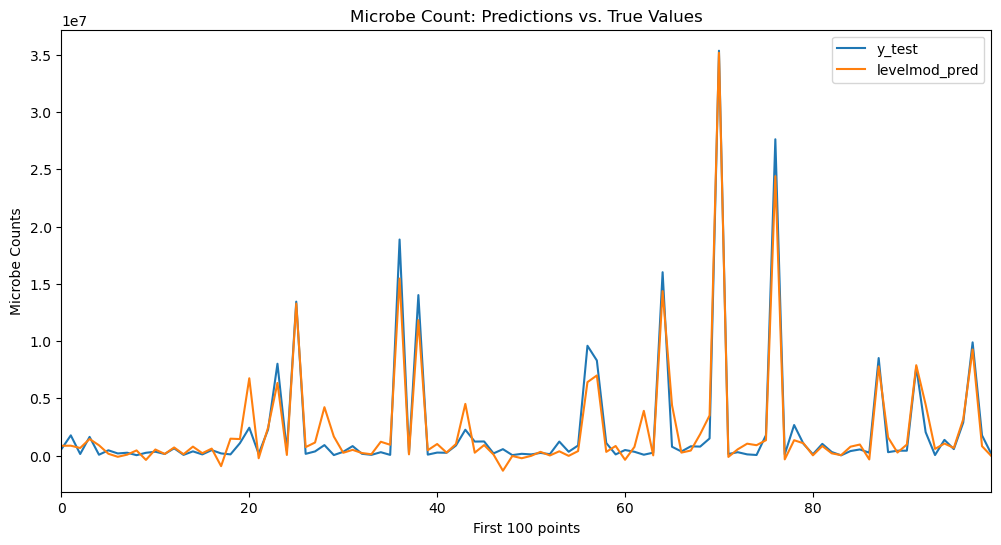

In [25]:
#Plot of level-level LightGBM model predictions vs the true values for first 100 observations of Microbe Cell Count
dfanalysis[['y_test', 'levelmod_pred']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight = True)
plt.title('Microbe Count: Predictions vs. True Values')
plt.xlabel('First 100 points')
plt.ylabel('Microbe Counts');

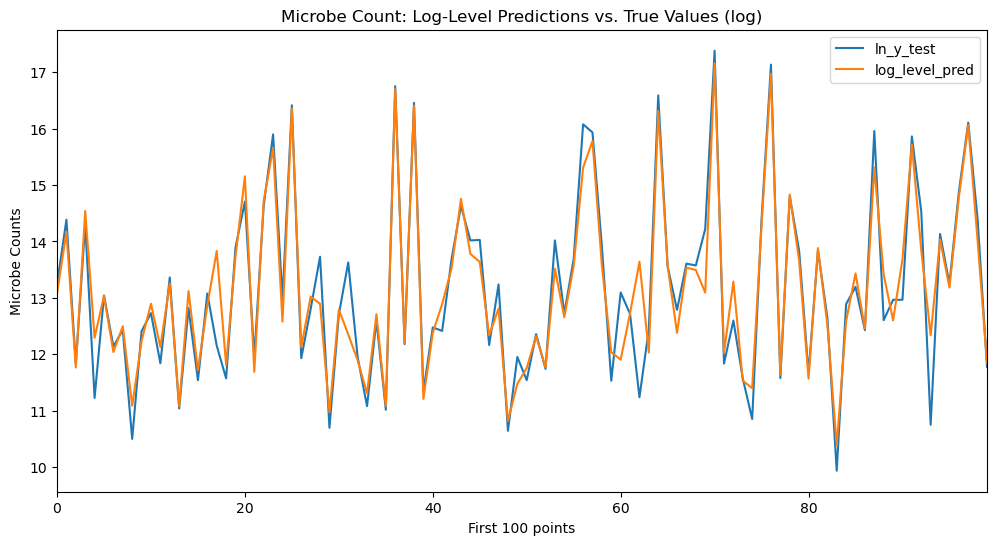

In [26]:
#Plot of log-level LightGBM model predictions vs the true values for first 100 observations of Microbe Cell Count
dfanalysis[['ln_y_test', 'log_level_pred']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight = True)
plt.title('Microbe Count: Log-Level Predictions vs. True Values (log)')
plt.xlabel('First 100 points')
plt.ylabel('Microbe Counts');

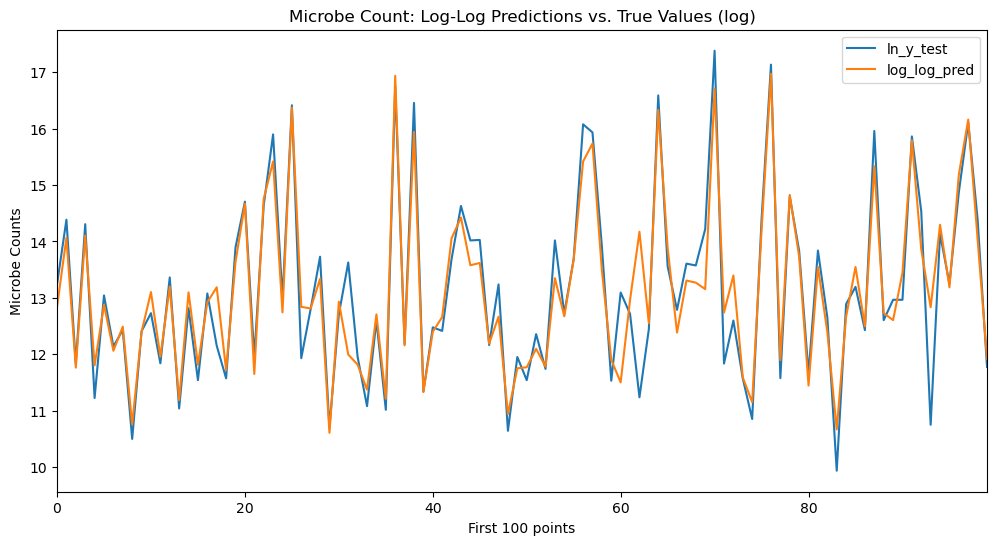

In [27]:
#Plot of log-log LightGBM model predictions vs the true values for first 100 observations of Microbe Cell Count
dfanalysis[['ln_y_test', 'log_log_pred']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight = True)
plt.title('Microbe Count: Log-Log Predictions vs. True Values (log)')
plt.xlabel('First 100 points')
plt.ylabel('Microbe Counts');